# Fish Detection on the Yellowfin Expt Optical Footage
### The goal of this project is to detect fish in the given optical footage from the Yellowfin Expt. If detection is successful, the detected fish could then be matched with their image in the Sonar Footage of the same scene. 

## To begin we will go through the detection process with one example

In [26]:
import cv2 as cv
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display
from PIL import Image
import os

### function for frame extraction

In [ ]:
# Function to extract frames
def FrameCapture(path):
  
    # Path to video file
    vidObj = cv.VideoCapture(path)
  
    # Used as counter variable
    count = 0
  
    # checks whether frames were extracted
    success = 1
  
    while success:
  
        # vidObj object calls read
        # function extract frames
        success, image = vidObj.read()

        if success == False: break
  
        # Saves the frames with frame-count
        cv.imwrite("./images/frame%d.jpg" % count, image)
  
        count += 1

## Load Model and Weights

In [27]:
net = cv.dnn.readNetFromDarknet('cfg/trained_on_merge/yolo-fish-2.cfg', 'weights/merge/merge_yolo-fish-2.weights')
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)

### Printing the layer names

In [28]:
ln = net.getLayerNames()
print(len(ln), ln)

263 ('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'le

### showing one image

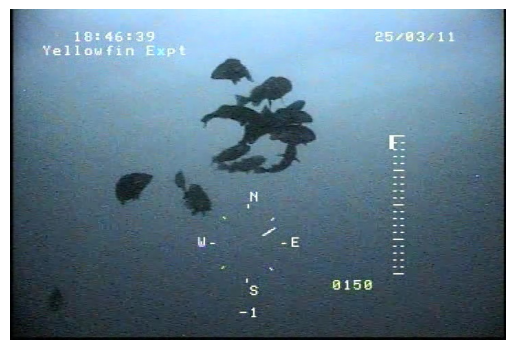

In [29]:
image_path = 'data_sets/raw_data_set/obj_train_data/frame2709.jpg'
img = cv.imread(image_path)
plt.axis('off')
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

## creating a blob from an image

### a blob is an image in the acceptable format for the model

(1, 3, 608, 608)


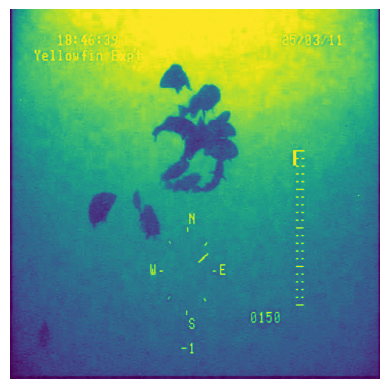

In [30]:
blob = cv.dnn.blobFromImage(img, 1/255.0, (608, 608), swapRB=False, crop=False)
r = blob[0, 0, :, :]
print(blob.shape)
plt.axis('off')
plt.imshow(r)

## Determine the output layers

In [31]:
# determine the output layer
ln = net.getLayerNames()
print(len(ln))
print(net.getUnconnectedOutLayers())
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
print(ln)

263
[209 236 263]
['yolo_89', 'yolo_101', 'yolo_113']


## Some helpful functions

In [32]:
def detect(blob):
    net.setInput(blob)
    t0 = time.time()
    outputs = net.forward(ln)
    t = time.time()
    return outputs

In [33]:
def parse_output(detection_outputs):
    boxes = []
    confidences = []
    classIDs = []
    h, w = img.shape[:2]

    for output in detection_outputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.5:
                box = detection[:4] * np.array([w, h, w, h])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                box = [x, y, int(width), int(height)]
                boxes.append(box)
                confidences.append(float(confidence))
                classIDs.append(classID)
    
    return classIDs, confidences, boxes

In [34]:
def write_output_file(filename, detection_outputs):
    f = open(filename, "w")
    boxes = []
    confidences = []
    classIDs = []

    for output in detection_outputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.5:
                box = detection[:4]
                boxes.append(box)
                confidences.append(float(confidence))
                classIDs.append(classID)
                f.write(f'{classID} {confidence} {box[0]} {box[1]} {box[2]} {box[3]}\n')
    f.close()

## Run the blob through the model

In [35]:
outputs = detect(blob)
classIDs, confidences, boxes = parse_output(outputs)
print(confidences)
print(boxes)

[0.9720625877380371, 0.8243376016616821, 0.6057446599006653, 0.7534658908843994]
[[328, 94, 82, 49], [148, 232, 61, 51], [145, 233, 68, 52], [247, 246, 46, 55]]


## Visualizing the result
### For visualization and accuracy metrics the library <https://github.com/rafaelpadilla/Object-Detection-Metrics/tree/master> will be used

In [36]:
import _init_paths
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes

(-0.5, 719.5, 479.5, -0.5)

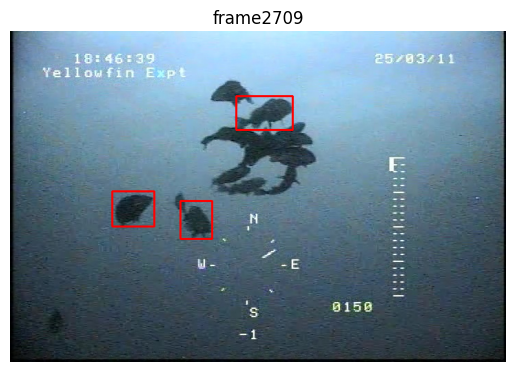

In [37]:
img_name = 'frame2709'
img_shape = img.shape

bounding_boxes = BoundingBoxes()

indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.5)

# adding detections 
if len(indices) > 0:
    for i in indices.flatten():
        detected_boundingBox = BoundingBox(img_name, 'Fish', x=boxes[i][0], y=boxes[i][1], w=boxes[i][2], h=boxes[i][3], typeCoordinates=CoordinatesType.Absolute,
                        bbType=BBType.Detected, format=BBFormat.XYWH, imgSize=(img_shape[1], img_shape[0]), classConfidence=confidences[i])
        bounding_boxes.addBoundingBox(detected_boundingBox) 


img = cv.imread(image_path) 
img = bounding_boxes.drawAllBoundingBoxes(img, img_name)
fig, ax = plt.subplots(1)
# Display the image
ax.set_title(img_name)
ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')

# Getting accuracy on the test set pre transfer learning
### Run the model for all images in the test set. Calculate the accuracy. Multiple yolo-fish models will be tested and the best performing one chosen for further training.

### loading the data set

In [38]:
def load_data_set(path):
    f = open(path, mode='r')
    data = [f'data_sets/{i.strip()}' for i in f.readlines()]
    return data

### function for loading detection data from an output file

In [39]:
def detections_from_txt(filename):
    detections = []
    f = open(filename, "r")
    lines = f.readlines()
    for line in lines:
        strings = line.split()
        detection = []
        for string in strings:
            detection.append(float(string))
        detections.append(detection)
    f.close()
    return detections

### functions for parsing detections

In [40]:
def get_boxes(detections, img, is_ground_truth):
    h, w = img.shape[:2]
    boxes = []
    for detection in detections:
        box = np.array(detection[1:5]) * np.array([w, h, w, h]) if is_ground_truth else np.array(detection[2:6]) * np.array([w, h, w, h])
        (centerX, centerY, width, height) = box.astype("int")
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))
        box = [x, y, int(width), int(height)]
        boxes.append(box)
    return boxes

In [41]:
def get_confidences(detections):
    confidences = []
    for detection in detections:
        confidences.append(detection[1])
    return confidences

### function for reading output files into BoundingBox objects to be used in visualization and metric calculations

In [42]:
def getBoundingBoxes(detections_path, data_set_path, data_set_size, data):
    bounding_boxes = BoundingBoxes()

    # getting bounding boxes
    for img_path in data:
        img = cv.imread(img_path)
        img_shape = img.shape
        img_name = os.path.splitext(os.path.basename(img_path))[0]

        ground_truths = detections_from_txt(f'{os.path.splitext(img_path)[0]}.txt')

        detections = detections_from_txt(f'{detections_path}/{img_name}.txt')
        detection_boxes = get_boxes(detections, img, False)
        detection_confidences = get_confidences(detections)
        indices = cv.dnn.NMSBoxes(detection_boxes, detection_confidences, 0.0, 0.5)

        # adding detections 
        if len(indices) > 0:
            for i in indices.flatten():
                detected_boundingBox = BoundingBox(img_name, 'Fish', x=detections[i][2], y=detections[i][3], w=detections[i][4], h=detections[i][5], typeCoordinates=CoordinatesType.Relative,
                                bbType=BBType.Detected, format=BBFormat.XYWH, imgSize=(img_shape[1], img_shape[0]), classConfidence=detections[i][1])
                bounding_boxes.addBoundingBox(detected_boundingBox) 
        
        # adding ground truths 
        for ground_truth in ground_truths:
            true_boundingBox = BoundingBox(img_name, 'Fish', x=ground_truth[1], y=ground_truth[2], w=ground_truth[3], h=ground_truth[4], typeCoordinates=CoordinatesType.Relative,
                                bbType=BBType.GroundTruth, format=BBFormat.XYWH, imgSize=(img_shape[1], img_shape[0]))
            bounding_boxes.addBoundingBox(true_boundingBox)

    return bounding_boxes

## An all in one function for testing a model. Returns a metrics object and bounding boxes.

In [43]:
from Evaluator import Evaluator

def TestModel(cfg_path, weights_path, data_set_path, output_path):
    # test a model on a data set, generate detection files in 'output_path', and return metrics and bounding boxes
    net = cv.dnn.readNetFromDarknet(cfg_path, weights_path)
    net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)

    # get output layer
    ln = net.getLayerNames()
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

    # load data set
    data = load_data_set(data_set_path+'/test.txt')
    data_set_size = len(data)

    # run model on test set and generate detection files
    for image_path in data:
        img = cv.imread(image_path)
        blob = cv.dnn.blobFromImage(img, 1/255.0, (608, 608), swapRB=True, crop=False)
        outputs = detect(blob)
        write_output_file(f'{output_path}/{os.path.basename(os.path.splitext(image_path)[0])}.txt', outputs)

    # load the bounding boxes for metric calculations
    bounding_boxes = getBoundingBoxes(output_path, data_set_path, data_set_size, data)

    # evaluate model performance on the test set
    evaluator = Evaluator()
    metrics = evaluator.GetPascalVOCMetrics(bounding_boxes, 0.5)

    return metrics, bounding_boxes
    

## Test the models

In [44]:
def print_metrics(metrics):
    for mc in metrics:
        # Get metric values per each class
        c = mc['class']
        precision = mc['precision']
        recall = mc['recall']
        average_precision = mc['AP']
        ipre = mc['interpolated precision']
        irec = mc['interpolated recall']
        total_pos = mc['total positives']
        true_pos = mc['total TP']
        false_pos = mc['total FP']
        # Print metrics
        print(f'AP = {average_precision}')
        #print(f'Recall = {recall}')
        #print(f'Ipre = {ipre}')
        #print(f'irec = {irec}')
        print(f'total positive = {total_pos}')
        print(f'true positive = {true_pos}')
        print(f'false positive = {false_pos}')

## Test on the YOLO-Fish test dataset

In [46]:
data_set_path = 'data_sets/merge-YOLO-Fish'

yolo_fish_1_cfg = 'cfg/trained_on_merge/yolo-fish-1.cfg'
yolo_fish_1_weights = 'weights/merge/merge_yolo-fish-1.weights'
yolo_fish_1_output = 'detections/YOLO-fish-1-merge-test'

yolo_fish_1_metrics, yolo_fish_1_boxes = TestModel(yolo_fish_1_cfg, yolo_fish_1_weights, data_set_path, yolo_fish_1_output)

In [47]:
print_metrics(yolo_fish_1_metrics)

AP = 0.5699075824955863
total positive = 11358
true positive = 6537.0
false positive = 329.0


In [48]:
data_set_path = 'data_sets/merge-YOLO-Fish'

yolo_fish_2_cfg = 'cfg/trained_on_merge/yolo-fish-2.cfg'
yolo_fish_2_weights = 'weights/merge/merge_yolo-fish-2.weights'
yolo_fish_2_output = 'detections/yolo-fish-2-merge-test'

yolo_fish_2_metrics, yolo_fish_2_boxes = TestModel(yolo_fish_2_cfg, yolo_fish_2_weights, data_set_path, yolo_fish_2_output)

In [49]:
print_metrics(yolo_fish_2_metrics)

AP = 0.5699075824955863
total positive = 11358
true positive = 6537.0
false positive = 329.0


### it seems we were not able to recreate to AP score as seen in the paper. This could be due to using slightly diferent metrics.

## Visualizing the results

In [50]:
def visualize(data_set_path, bounding_boxes, max=-1):
    data = load_data_set(data_set_path+'/test.txt')
    data_set_size = len(data)
    
    count = 0
    for img_path in data:
            if count > max and max != -1:
                  break
            img_name = os.path.splitext(os.path.basename(img_path))[0]
            im = cv2.imread(os.path.join(data_set_path,'data', img_name)+'.jpg')
            im = bounding_boxes.drawAllBoundingBoxes(im, img_name)

            fig, ax = plt.subplots(1)
            # Display the image
            ax.set_title(img_name)
            ax.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
            plt.axis('off')
            plt.draw()
            display.clear_output(wait=True)
            display.display(fig)
            plt.close()
            count += 1

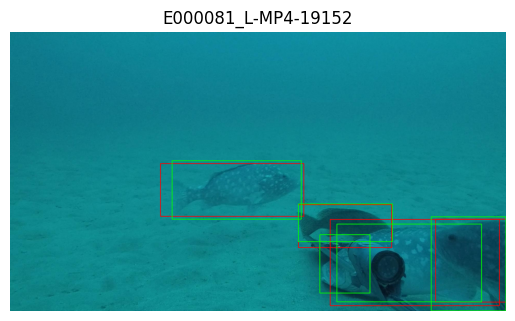

In [51]:
visualize(data_set_path, yolo_fish_2_boxes, 100)

## Test on yellowfin data set

In [52]:
data_set_path = 'data_sets/80.0_shuffled_split/test'

In [53]:
yolo_fish_1_cfg = 'cfg/trained_on_merge/yolo-fish-1.cfg'
yolo_fish_1_weights = 'weights/merge/merge_yolo-fish-1.weights'
yolo_fish_1_output = 'detections/yolo-fish-1-merge-pre-training'

yolo_fish_1_metrics, yolo_fish_1_boxes = TestModel(yolo_fish_1_cfg, yolo_fish_1_weights, data_set_path, yolo_fish_1_output)

In [54]:
print_metrics(yolo_fish_1_metrics)

AP = 0.006271030896298562
total positive = 934
true positive = 6.0
false positive = 1.0


In [55]:
yolo_fish_2_cfg = 'cfg/trained_on_merge/yolo-fish-2.cfg'
yolo_fish_2_weights = 'weights/merge/merge_yolo-fish-2.weights'
yolo_fish_2_output = 'detections/yolo-fish-2-merge-pre-training'

yolo_fish_2_metrics, yolo_fish_2_boxes = TestModel(yolo_fish_1_cfg, yolo_fish_1_weights, data_set_path, yolo_fish_2_output)

In [56]:
print_metrics(yolo_fish_2_metrics)

AP = 0.006271030896298562
total positive = 934
true positive = 6.0
false positive = 1.0


# Do to the lack of fish being detected the model will need to be improved for detection of fish in the data set
### The errors are likely due to the [YOLO-Fish](https://github.com/tamim662/YOLO-Fish) model being trained on the [OzFish](https://apps.aims.gov.au/metadata/view/38c829d4-6b6d-44a1-9476-f9b0955ce0b8) and [DeepFish](https://github.com/alzayats/DeepFish) data sets containg fish speicies not present in our data set.
### Transfer learning can be used to further train the model on a subset of the Yellowfin Expt data set. We will further train the model on the dataset using [Darknet](https://pjreddie.com/darknet/). 
### Darknet command ```./darknet detector train Dataset/obj.data cfg/yolo-fish-2.cfg backup/merge_yolo-fish-2.weights```

# Retesting using weights after transfer learning on the training set

In [57]:
data_set_path = 'data_sets/80.0_shuffled_split/test'

In [58]:
yolo_fish_2_cfg = 'cfg/trained_on_merge/yolo-fish-2.cfg'
yolo_fish_2_retrained_weights = 'weights/retrained/yolo-fish-2_retrained.weights'
yolo_fish_2_retrained_output = 'detections/yolo-fish-2-merge-post-training'

yolo_fish_2_retrained_metrics, yolo_fish_2_retrained_boxes = TestModel(yolo_fish_2_cfg, yolo_fish_2_retrained_weights, data_set_path, yolo_fish_2_retrained_output)

In [59]:
print_metrics(yolo_fish_2_retrained_metrics)

AP = 0.006271030896298562
total positive = 934
true positive = 6.0
false positive = 1.0


## Visualize the detections

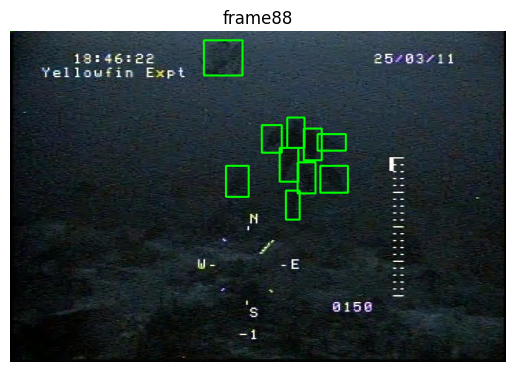

In [60]:
visualize(data_set_path, yolo_fish_2_retrained_boxes)

# Comparing accuracy

In [61]:
print('Pre-training Metrics: ')
print_metrics(yolo_fish_2_metrics)

print('Post-training Metrics: ')
print_metrics(yolo_fish_2_retrained_metrics)

Pre-training Metrics: 
AP = 0.006271030896298562
total positive = 934
true positive = 6.0
false positive = 1.0
Post-training Metrics: 
AP = 0.006271030896298562
total positive = 934
true positive = 6.0
false positive = 1.0


### It seems that the model has not improved much with the new weights. 

# As a final attempt to get better results, we will split the original data set temporally instead of randomly. 
## This means the test set will be the last 20% of the images. The last images have better lighting and background conditions that may help the model perform better.

In [62]:
data_set_path = 'data_sets/80.0_temporal_split/test'

In [68]:
yolo_fish_2_cfg = 'cfg/trained_on_merge/yolo-fish-2.cfg'
final_retrained_weights = 'weights/retrained/yolo-fish-2_temporal.weights'
temporal_retrained_output = 'detections/yolo-fish-2-merge-temporal-post-training'

temporal_retrained_metrics, temporal_retrained_boxes = TestModel(yolo_fish_2_cfg, final_retrained_weights, data_set_path, temporal_retrained_output)

### metrics

In [69]:
print_metrics(temporal_retrained_metrics)

AP = 0.02817260091393755
total positive = 1010
true positive = 29.0
false positive = 4.0


### visualization

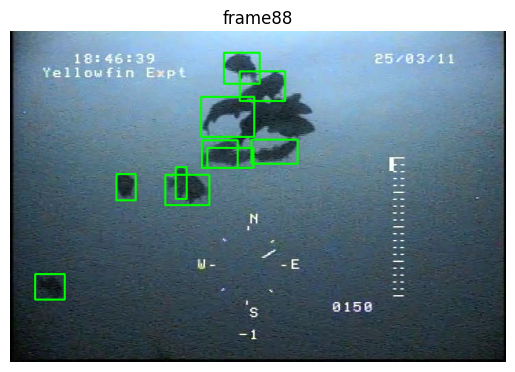

In [71]:
visualize(data_set_path, temporal_retrained_boxes)

### performance is slightly better but still not great

# Conclusion
### The lack of performance is likely due to the quality of the images being too low (Low light, resulution, strange angles) for the model to perform well in most cases. There could also be an error in the way the models are being used leading to the inability to match the AP score found in the YOLO-Fish paper and the under performance on our dataset. Preproccessing techniques could be used to improve the quality of the images before they are given to the model. Furthermore, with more training data, training optimization, and modifying the YOLO-Fish model the accuracy could be improved.